# Kaggle Playground Series S-5 ep-4

### Dependencies

In [73]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split

In [61]:
sns.set_theme(style = "darkgrid")
warnings.filterwarnings("ignore")

### Preparing the Dataframe

In [62]:
df = pd.read_csv(os.path.join("Data","train.csv"))
df.set_index(df["id"],inplace=True)
df.drop(columns = ["id","Episode_Title","Publication_Day","Publication_Time","Podcast_Name"],inplace=True)
df.head()

,Episode_Length_minutes,Genre,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,
0,NaN,True Crime,74.81,NaN,0.0,Positive,31.41998
1,119.80,Comedy,66.95,75.95,2.0,Negative,88.01241
2,73.90,Education,69.97,8.97,0.0,Negative,44.92531
3,67.17,Technology,57.22,78.70,2.0,Positive,46.27824
4,110.51,Health,80.07,58.68,3.0,Neutral,75.61031


In [63]:
print(df.isna().sum())
df["Episode_Length_minutes"].fillna(df["Episode_Length_minutes"].mean(),inplace=True)
df["Guest_Popularity_percentage"].fillna(df["Guest_Popularity_percentage"].mean(),inplace=True)
df["Number_of_Ads"].fillna(0.0,inplace=True)
print("==============================================")
print(df.isna().sum())

Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
dtype: int64


In [64]:
sameple_df = df.sample(n = 5000)
sameple_df.head()

,Episode_Length_minutes,Genre,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,
440753,64.504738,Music,37.36,52.236449,3.0,Negative,48.50705
648144,119.490000,Sports,32.51,66.000000,1.0,Neutral,98.69389
345381,33.620000,Health,55.05,56.050000,3.0,Neutral,28.06790
100552,69.860000,Business,85.73,39.080000,1.0,Negative,46.24968
169416,28.730000,True Crime,41.66,52.236449,0.0,Neutral,15.70229


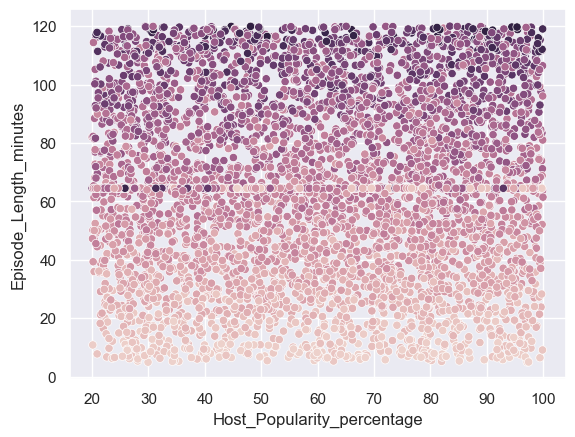

In [65]:
sns.scatterplot(data=sameple_df,x = "Host_Popularity_percentage",y = "Episode_Length_minutes",hue = "Listening_Time_minutes",legend=False)
plt.show()

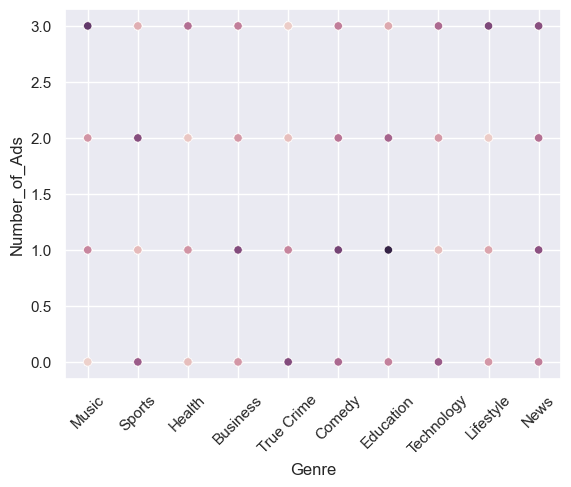

In [66]:
sns.scatterplot(data=sameple_df,x = "Genre",y = "Number_of_Ads",hue = "Listening_Time_minutes",legend=False)
plt.xticks(rotation = 45)
plt.show()

### Preprocessing

In [67]:
genre_columns = df["Genre"].unique()
ep_sentiment_columns = df["Episode_Sentiment"].unique()


print(f"Genre Columns: {genre_columns}")
print("=======================================")
print(f"Episode Sentiment Columns: {ep_sentiment_columns}")

Genre Columns: ['True Crime' 'Comedy' 'Education' 'Technology' 'Health' 'News' 'Music'
 'Sports' 'Business' 'Lifestyle']
Episode Sentiment Columns: ['Positive' 'Negative' 'Neutral']


In [70]:
def Preprocessing(df):
    genre_df = pd.get_dummies(df["Genre"],prefix="Genre_",dtype="int")
    ep_sentiment_df = pd.get_dummies(df["Episode_Sentiment"],prefix="Episode_Sentiment_",dtype="int")

    df = pd.concat([df,genre_df],axis = 1)
    df = pd.concat([df,ep_sentiment_df],axis = 1)

    df.drop(columns = ["Genre","Episode_Sentiment"],inplace=True)
    return df

In [71]:
preprocessed_df = Preprocessing(df)
preprocessed_df.head()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes,Genre__Business,Genre__Comedy,Genre__Education,Genre__Health,Genre__Lifestyle,Genre__Music,Genre__News,Genre__Sports,Genre__Technology,Genre__True Crime,Episode_Sentiment__Negative,Episode_Sentiment__Neutral,Episode_Sentiment__Positive
id,,,,,,,,,,,,,,,,,,
0,64.504738,74.81,52.236449,0.0,31.41998,0,0,0,0,0,0,0,0,0,1,0,0,1
1,119.800000,66.95,75.950000,2.0,88.01241,0,1,0,0,0,0,0,0,0,0,1,0,0
2,73.900000,69.97,8.970000,0.0,44.92531,0,0,1,0,0,0,0,0,0,0,1,0,0
3,67.170000,57.22,78.700000,2.0,46.27824,0,0,0,0,0,0,0,0,1,0,0,0,1
4,110.510000,80.07,58.680000,3.0,75.61031,0,0,0,1,0,0,0,0,0,0,0,1,0


### Splitting the Data

In [78]:
X = preprocessed_df.drop(columns = ["Listening_Time_minutes"]).values
y = preprocessed_df["Listening_Time_minutes"].values

In [81]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.2)
print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (600000, 17)
y_train Shape: (600000,)
X_test Shape: (150000, 17)
y_test Shape: (150000,)


### Building the Model

In [72]:
reg = xgb.XGBRegressor(n_estimators = 200,
                       max_depth = 10,
                       max_leaves = 10,
                       learning_rate = 0.0001,
                       verbose = 3)